In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
#words[:5]

In [3]:
# build the vocab of chars and mappings to/from ints
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} # chars from 1-26 are alpha
stoi['.'] = 0 # special char to delineate begin/end of word
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
#print(itos)

In [4]:
block_size = 3 # context length, how many chars we take to predict the next one
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
batch_size = 32
max_steps = 200000
decay_at = 10000

In [5]:
# build the dataset (split into 3)

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size # padded tokens
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    #print(X.shape,Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words) # randomly shuffle words (so unsorted)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # build training dataset (words 80% of dataset)
Xdev, Ydev = build_dataset(words[n1:n2]) # build dev dataset (words 80-90, so 10%)
Xte, Yte = build_dataset(words[n2:]) # build test dataset (words 90-100, so last 10% of dataset)

In [6]:
#block_size * LUT_dim

In [28]:
# params
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size,n_embd), generator=g) # puts 27 chars in 10 dims
W1 = torch.randn((block_size * n_embd ,n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01 # will be broadcasted when added to W1
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.01 # scaled down initialized weight
b2 = torch.randn(vocab_size, generator=g) * 0 # b2 is 0 at initialization
parameters = [C,W1,b1,W2,b2]

sum(p.nelement() for p in parameters)

for p in parameters:
    p.requires_grad = True

In [29]:
# TRAINING LOOP using minibatches
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb] # UPDATED build LUT embedding matrix, (32, num of chars (3), dims of LUT (10) )
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # (batch_size, hidden_layer_size) hidden layer
    logits = h @ W2 + b2 # (batch_size,27)
    loss = F.cross_entropy(logits,Yb) # replaces counts, prob and loss lines above
    
    # backward pass
    for p in parameters:
        p.grad = None # initialize grad vals to 0
    loss.backward() # populates gradients

    # update parameters
    #lr = lrs[i]
    lr = 0.1 if i < decay_at else 0.01 # decay after 100,000 steps
    for p in parameters:
        p.data += -lr * p.grad 
        
    # track stats for learning rates
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item(): .4f}')
    lossi.append(loss.log10().item()) # track log loss 
                   
    break
        
#print(loss.item()) # calculates loss on minibatch

      0/ 200000:  3.3135


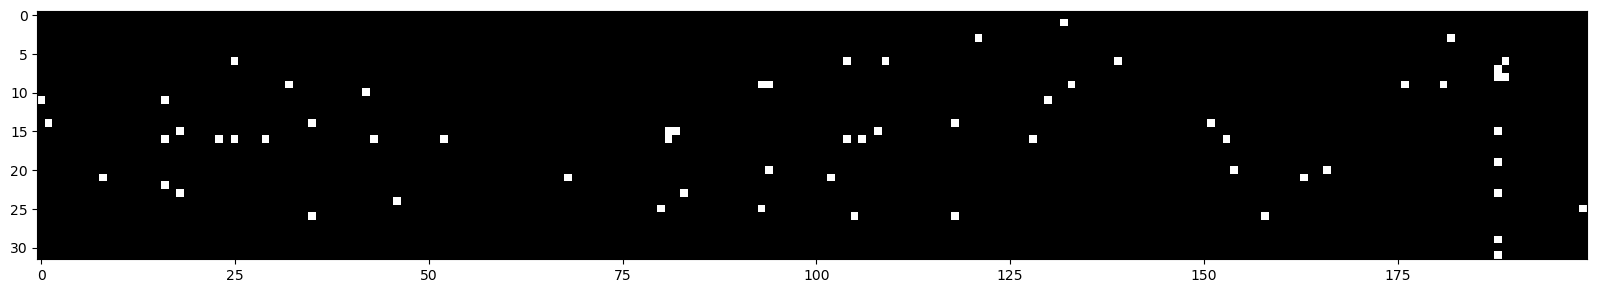

In [30]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

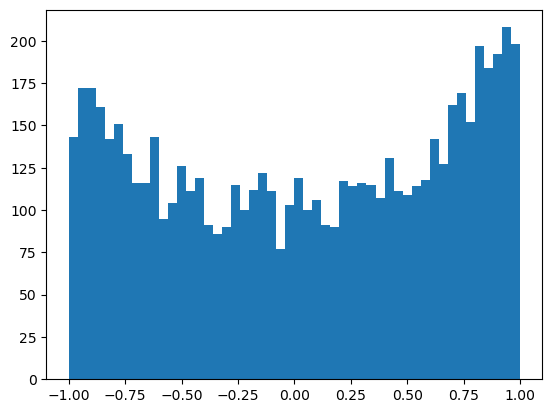

In [31]:
# view() stretches it out into one long 1D vector
# tolist() converts into one long python list of floats
# only show 50 bins 
# and semicolon to supress output we don't want
plt.hist(h.view(-1).tolist(),50);

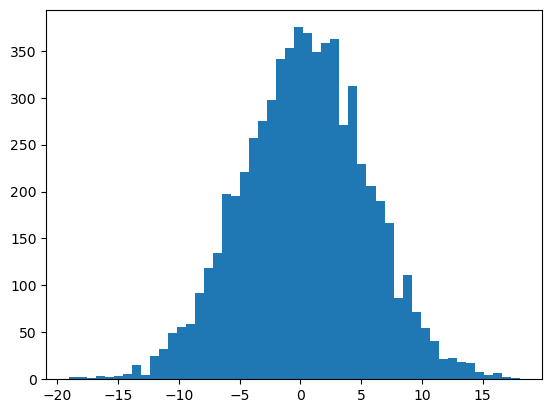

In [25]:
plt.hist(hpreact.view(-1).tolist(),50);

In [21]:
# calculate negative log probability of uniform distribution for initialization
# should be 1/27.0
-torch.tensor(1/27.0).log()

tensor(3.2958)

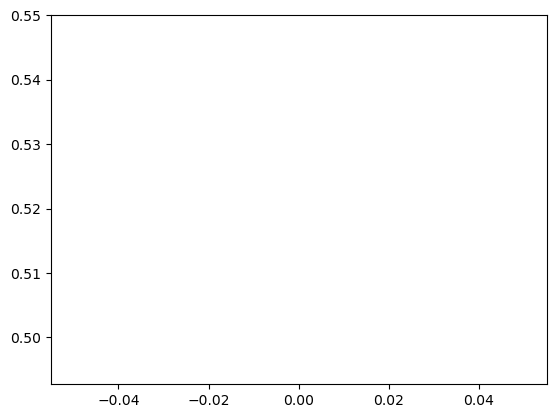

In [11]:
plt.plot(lossi)

In [12]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split): # argument is which split you want to evaluate
    x,y = {
        'train': (Xtr,Ytr),
        'val': (Xdev,Ydev), # validation/dev dataset
        'test': (Xte,Yte),
    }[split]
    
    # forward pass of network and evaluation of loss for split
    emb = C[x] #(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0],-1) #concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split,loss.item())
    
split_loss('train')
split_loss('val')

train 3.1878931522369385
val 3.187795877456665


In [13]:
# sample from model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # init iwith all ..
    
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd) # dim 1 because we're making one example
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2 # get probabilities from model
        probs = F.softmax(logits, dim=1) # exponentiate logits to sum to 1
        ix = torch.multinomial(probs,num_samples=1, generator=g).item() # grab random sample (random char from distribution)
        context = context[1:] + [ix] # shift context window
        out.append(ix) # record context window
        
        # if we sample the special '.' token, break
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out)) # decode and print the generated word

cbrpzhxqtb.
hqvufkwmrpxqthtykhkcasskejrzhnbnfqplsyhc.
vgqhiu.
rrmuqptcmziivdyxlhggphhlm.
poin.
qbqjtzsrlivwa.
vvdbquwqzthogdjaryxixfkqeupiusdbwed.
ecoia.
gtlffhysflquhpagmbvdjhksyjrpmqqosozswjcojqmwyljifrenqkpfsadlnuo.
zoebsrkoiazhrynhr.
opklhynrxyh.
xqioloqbplbvbwdn.
ip.
qmuitjpbvfpzpddgpycsislqwkkmco.
zauqnyjydpk.
kvweskatikzamdtevl.
ky.
qdyltoorowooktbymouokfbfcw.
zoindzcs.
au.


Where I left off:
https://youtu.be/P6sfmUTpUmc?t=804